Dependencies and Setup

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import requests, time
from scipy.stats import linregress
from citipy import citipy  # Incorporated citipy to determine city based on latitude and longitude
# Import API key
from config import weather_api_key as api_key
from iso3166 import countries_by_alpha2  # pip install iso3166

sns.set(rc={'figure.dpi': 300, 'savefig.dpi': 300})
sns.set_context('notebook')


def k_to_f(temp):
    temp = round((temp - 273.15) * 9 / 5 + 32, 2)
    return temp


def kmh_to_mph(speed):
    return speed * 0.621371


def north_or_south(latitude):
    return latitude < 0


# output file
output_file = "output_data/cities.csv"

Range of latitudes and longitudes

In [4]:
lat_range = (-90, 90)
lng_range = (-180, 180)

lats = [np.random.uniform(lat_range[0], lat_range[1]) for i in range(3000)]
lngs = [np.random.uniform(lng_range[0], lng_range[1]) for i in range(3000)]

lat_lngs = list(zip(lats, lngs))

cities = []

for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    city = city.strip()
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

print(len(cities))

1024


In [110]:
temp_dict = {}
# {city:[lat, long, max_temp, humidity, windspeed, country]}
# 0 = lat
# 1 = long
# 2 = max_temp
# 3 = humidity
# 4 = windspeed
# 5 = country

i, j = 0, 0

for city in cities:
    if i < 50:
        search_str = f'http://api.openweathermap.org/data/2.5/weather?q={city}&appid={api_key}'
        resp = requests.get(search_str)
        if resp.status_code == 200:
            resp = resp.json()
            vs = [
                    resp['coord']['lat'],
                    k_to_f(resp['main']['temp_max']),
                    resp['main']['humidity'],
                    kmh_to_mph(resp['wind']['speed']),
                    resp['clouds']['all']
            ]
            temp_dict[city] = vs
            i += 1
            print(f'Request {j}: {city} request successful.')
        else:
            print(f'Request {j}: {city} request failed.')
        j += 1
    else:
        print(
                f'{i} successful requests made.\n'
                f'{round(i / j * 100, 2)}% of requests succeeded.'
        )
        break

Request 0: kaitangata request successful.
Request 1: kifri request successful.
Request 2: punta arenas request successful.
Request 3: marawi request successful.
Request 4: rikitea request successful.
Request 5: ushuaia request successful.
Request 6: arraial do cabo request successful.
Request 7: bredasdorp request successful.
Request 8: ulladulla request successful.
Request 9: cape town request successful.
Request 10: thompson request successful.
Request 11: mataura request successful.
Request 12: vaitape request successful.
Request 13: chokurdakh request successful.
Request 14: olinda request successful.
Request 15: morgan city request successful.
Request 16: qaqortoq request successful.
Request 17: santa maria request successful.
Request 18: takoradi request successful.
Request 19: xingyi request successful.
Request 20: grand centre request failed.
Request 21: mar del plata request successful.
Request 22: lebu request successful.
Request 23: victoria request successful.
Request 24: p

In [113]:
dft = pd.DataFrame(temp_dict).T
dft.columns = ['Latitude','Max Temperature (F)', 'Humidity', 'Wind Speed', 'Clouds']
dft['is_south'] = dft['Latitude'].apply(lambda x: 1 if x < 0 else 0)
dft.head()


,Latitude,Max Temperature (F),Humidity,Wind Speed,Clouds,is_south
kaitangata,-46.2817,58.68,74.0,2.255577,77.0,1
kifri,34.6959,65.75,22.0,1.435367,3.0,0
punta arenas,-53.1500,33.91,93.0,3.833859,90.0,1
marawi,7.9986,77.65,54.0,0.739431,15.0,0
rikitea,-23.1203,74.68,78.0,4.548436,46.0,1


KeyError: ('Max Temperature (F)', 'is_south')

In [125]:

def make_figures(name, df, x='Latitude', y=None, hue_by=None):
    sns.scatterplot(
            x=x,
            y=y,
            data=df,
            hue=hue_by,
            palette='plasma',
            alpha=0.8,
            edgecolor='b',
            legend=False
    )
    title = f'{name.title()} - {y} vs {x}'
    plt.title(title)
    plt.savefig(f'{title}.png')
    plt.close()
    return

In [115]:
df_north = dft[dft['is_south'] == 0]
df_south = dft[dft['is_south'] == 1]

In [126]:
dfs = [df_south, df_north]
names = ['south', 'north']
ys = ['Max Temperature (F)', 'Humidity (%)', 'Wind Speed (mph)', 'Clouds (%)']


for name, frame in zip(names, dfs):
    for y in ys:
        make_figures(name, frame, y=y)
    # print(, frame.head())

ValueError: Could not interpret value `Humidity (%)` for parameter `y`

In [72]:
df[df['is_south'] == 1]


,Latitude,long,Max Temperature (F),Humidity,Wind Speed,country,is_south
kaitangata,-46.2817,169.8464,59.7,73,2.268004,New Zealand,1
punta arenas,-53.15,-70.9167,39.31,60,3.51696,Chile,1
rikitea,-23.1203,-134.9692,74.8,77,4.467657,French Polynesia,1
ushuaia,-54.8,-68.3,35.26,69,4.796984,Argentina,1
arraial do cabo,-22.9661,-42.0278,71.01,91,5.281654,Brazil,1
...,...,...,...,...,...,...,...
san rafael,-34.6177,-68.3301,71.76,19,3.802791,Argentina,1
valenca do piaui,-6.4075,-41.7456,75.6,78,0.826423,Brazil,1
ballina,-28.8667,153.5667,71.64,73,2.876948,Australia,1
mahebourg,-20.4081,57.7,74.25,78,3.51696,Mauritius,1


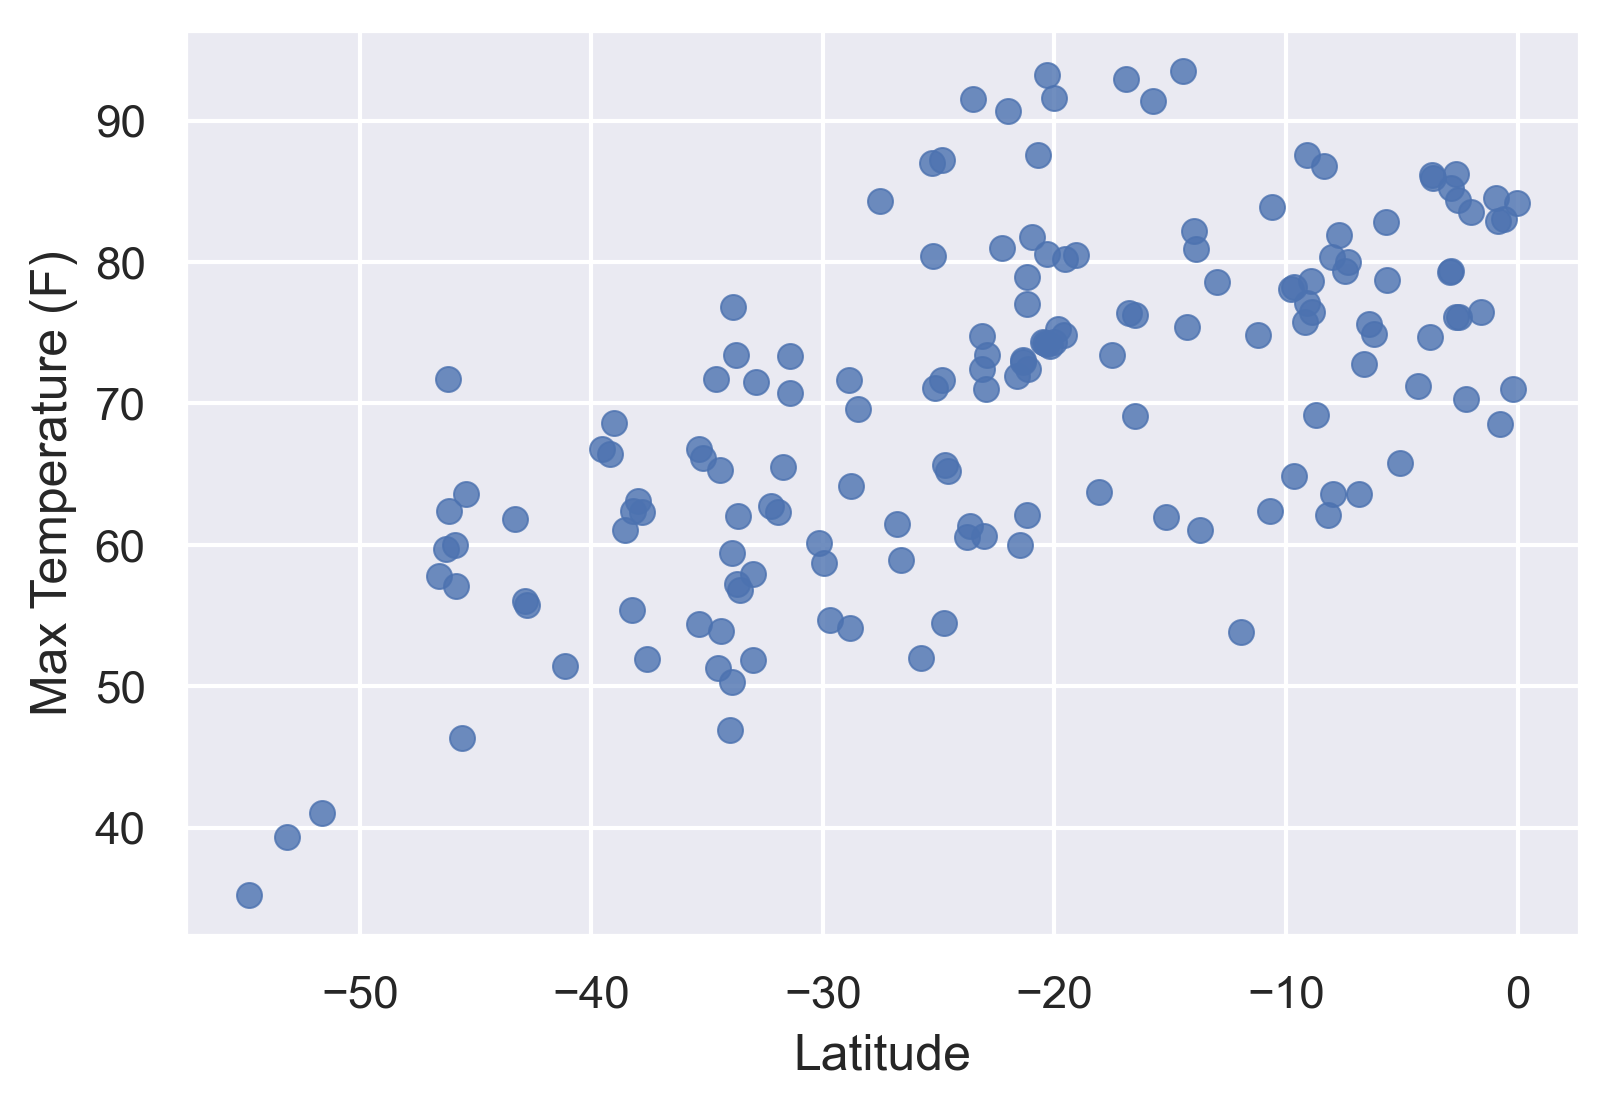

In [79]:
make_figures('southttt', df_south, y='Max Temperature (F)')

In [89]:
a = range(1,10,2)
b = range(0, 10, 2)
for x,y in zip(a,b):
    print(x,y)

1 0
3 2
5 4
7 6
9 8


In [109]:
resp['clouds']['all']

81